In [1]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [2]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [3]:
df1 = pd.read_csv("../data/female-mirror-data.csv")
df1["Action"] = df1["Action"].str.rstrip()
df1.head()

,Female Participant Number,Action,video-name,Unnamed: 3
0,1,Normal,1-FemaleNoGlasses-Normal.avi,NaN
1,1,Talking,1-FemaleNoGlasses-Talking.avi,NaN
2,1,Yawning,1-FemaleNoGlasses-Yawning.avi,NaN
3,2,Normal,2-FemaleNoGlasses-Normal.avi,C:\Users\bnich\Documents\_MyDocs\_School\2022-...
4,2,Talking,2-FemaleNoGlasses-Talking.avi,C:\Users\bnich\Documents\_MyDocs\_School\2022-...


In [4]:
df1["target"] = (df1["Action"]=="Yawning")

In [5]:
i = 0
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()

while i<len(df1)/10:
    if i%5==0:
        dfTest = dfTest.append(df1.iloc[[i]])
    else :
        dfTrain = dfTrain.append(df1.iloc[[i]])

    i+=1

In [11]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video-name"].values.tolist()
    labels = df["target"].values

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [12]:
train_data, train_labels = prepare_all_videos(dfTrain, "../data/YawDD/YawDD dataset/Mirror/Female_mirror/")
test_data, test_labels = prepare_all_videos(dfTest, "../data/YawDD/YawDD dataset/Mirror/Female_mirror/")
print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (12, 20, 1024)


In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [27]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = 1

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()
    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return model

In [28]:
trained_model = run_experiment()

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 1.1946 - accuracy: 0.6000 - val_loss: 4.6469 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 4.64694, saving model to tmp\video_classifier
Epoch 2/5
1/1 [==============================] - 0s 112ms/step - loss: 3.8615 - accuracy: 0.7000 - val_loss: 1.6959 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 4.64694 to 1.69586, saving model to tmp\video_classifier
Epoch 3/5
1/1 [==============================] - 0s 110ms/step - loss: 2.1495 - accuracy: 0.3000 - val_loss: 2.9922 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 1.69586
Epoch 4/5
1/1 [==============================] - 0s 108ms/step - loss: 1.9781 - accuracy: 0.7000 - val_loss: 3.4687 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 1.69586
Epoch 5/5
1/1 [==============================] - 0s 118ms/step - loss: 1.6730 - accuracy: 0.7000 - val_loss: 2.0137 - val_accuracy: 0.5000

Epoch 00005: val_lo

Test video path: 6-FemaleNoGlasses-Normal.avi
  Yawning: 79.01%



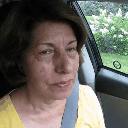

In [30]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = ["Yawning"]

    frames = load_video(os.path.join("../data/YawDD/YawDD dataset/Mirror/Female_mirror/", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(dfTest["video-name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])